# Lookup table inversion
## Using exact solution values
### Three layer model conductivity

In [38]:
import empymod
import numpy as np
import matplotlib.pyplot as plt
import time
from joblib import Parallel, delayed
from scipy.constants import mu_0

### Define the geometry of device

In [39]:
# Define Dualem-482 geometry

offsets = np.array([2, 4, 8]) # in meters
height = -0.10 # meters height From ground surface to center of coils
rad = 0.08 # Define radius of coil (8 cm)

# Source and receivers geometry

# For HCP
Hsource = [-rad, rad, -rad, rad, height, height]
Hreceivers = [offsets-rad, offsets+rad,
              np.ones(3)*-rad, np.ones(3)*rad, height, height]

# For VCP
Vsource = [0, 0, height, 90, 0]
Vreceivers = [offsets, offsets*0, height, 90, 0]

# For PRP
Psource = [0, 0, height]
Preceivers = [offsets, offsets*0, height]

# Frequency
freq = 9000

### Define the properties of the models of the lookup table

In [40]:
# sampling of conductivities
nsl = 14

s0 = -2 # minimum conductivity in S/m
s1 = -0.5 # maximum conductivity in S/m
# conductivities array
conds = np.logspace(s0, s1, nsl)

# Sampling of 1st layer thickness
th0 = 0.1 # minimum thickness in m
th1 = 5   # maximum thickness in m
# thickness array
thicks = np.linspace(th0, th1, nsl)

### Define forward function that provides values of quadrature for each geometry

In [41]:
def EMforward(sigma1, sigma2, sigma3, thicks1, thicks2):
    time.sleep(0.01)
    
    res =[2e14, 1/sigma1, 1/sigma2, 1/sigma3]
    depth=[0, thicks1, thicks1+thicks2]

    # Compute fields
    HCP_Hs = empymod.loop(Hsource, Hreceivers, depth, res, freq, xdirect=None, mrec = 'loop', verb=0)
    VCP_Hs = empymod.loop(Vsource, Vreceivers, depth, res, freq, xdirect=None, mrec = 'loop', verb=0)
    PRP_Hs = empymod.dipole(Psource, Preceivers, depth, res, freq, ab=64, xdirect=None, verb=0)

    HCP_Hp = empymod.loop(Hsource, Hreceivers, depth=[], res=[2e14], freqtime=freq, mrec = 'loop', verb=0)
    VCP_Hp = empymod.loop(Vsource, Vreceivers, depth=[], res=[2e14], freqtime=freq, mrec = 'loop', verb=0)
    PRP_Hp = empymod.dipole(Psource, Preceivers, depth=[], res=[2e14], freqtime=freq, ab=66, verb=0)

    Q_HCP = (np.imag(HCP_Hs/HCP_Hp))
    Q_VCP = (np.imag(VCP_Hs/VCP_Hp))
    Q_PRP = (np.imag(PRP_Hs/PRP_Hp))
    
    P_HCP = (np.real(HCP_Hs/HCP_Hp))
    P_VCP = (np.real(VCP_Hs/VCP_Hp))
    P_PRP = (np.real(PRP_Hs/PRP_Hp))
    
    return np.hstack((Q_HCP, Q_VCP, Q_PRP, P_HCP, P_VCP, P_PRP))

### Calculate the solutions for all the models

In [42]:
startTime = time.time()

Qexact = Parallel(n_jobs=-1,verbose=1)(delayed(EMforward)(sigma1, sigma2, sigma3, thick1, thicks2) 
            for sigma1 in conds for sigma2 in conds for sigma3 in conds for thick1 in thicks for thicks2 in thicks)

executionTime = (time.time() - startTime)
print('Execution time in seconds: ' + str(executionTime))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 976 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 2976 tasks      | elapsed:   13.1s
[Parallel(n_jobs=-1)]: Done 5776 tasks      | elapsed:   23.1s
[Parallel(n_jobs=-1)]: Done 9376 tasks      | elapsed:   35.8s
[Parallel(n_jobs=-1)]: Done 13776 tasks      | elapsed:   51.6s
[Parallel(n_jobs=-1)]: Done 18976 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 24976 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 31776 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 39376 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 47776 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 56976 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 66976 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 77776 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done 89376 t

Execution time in seconds: 2251.123938560486


[Parallel(n_jobs=-1)]: Done 537824 out of 537824 | elapsed: 37.5min finished


### Functions to search model in lookup table

In [43]:
def gridsearch(Qdata):
    err = 1
    indx=0
    for i in range(np.shape(Qexact)[0]):
        nZdiff = np.abs(Qexact[i] - Qdata) **2 / np.abs(Qdata)**2
        merr = np.log(np.sqrt(np.sum(nZdiff)))
        if merr < err:
            indx = i
            err = merr.copy()
   # print(nZdiff)
   # print(merr)
    return indx

def invert(index):
    for i in range(len(conds)):
        for j in range(len(conds)):
            for k in range(len(conds)):
                for m in range(len(thicks)):
                    for n in range(len(thicks)):
                        idx = n + m*nsl + k*nsl**2 + j*nsl**3 + i*nsl**4
                        if index == idx:
                            model = np.array([conds[i], conds[j], conds[k], thicks[m], thicks[n]])
                            return model

### Create a two layered 2D section with calculated solutions

In [48]:
# parameters for the synthetic model

nlayer = 3 # number of layer
npos = 14 # number of sampling positions

sig_ini = [conds[1], conds[13], conds[1]]
sigmas = np.ones((npos, nlayer))*sig_ini

x = np.linspace(0, npos, npos)
thk1 = np.ones_like(x) * thicks[4]    # wave
thk2 = np.ones_like(x) * thicks[4]
thk2[7:] = thicks[7:]

depths = np.zeros((npos, nlayer))
depths[:,1] = thk1
depths[:,2] = thk1+thk2

In [49]:
def PlotModel(sigmas, depth):
    # Arrays for plotting
    depthmax=10
    ny = 50
    y = np.linspace(0, depthmax, ny)
    sigy = np.zeros((npos, ny))

    # Conductivities array to be plotted
    for i in range(npos):
        y1=0
        while y[y1] <= depth[i, 1]:
            sigy[i, y1] = sigmas[i, 0]
            y1 += 1
            y2=y1
        while y[y2] <= depth[i, 2]:
            sigy[i, y2] = sigmas[i, 1]
            y2 += 1
            if y2 == 50:
                break
        sigy[i, y2:] = sigmas[i, 2]
    
    fig, ax = plt.subplots()
    pos = ax.imshow(sigy.T, cmap='viridis', interpolation='none', extent=[0,npos,10,0], 
                    vmin = np.min(conds), vmax=np.max(conds) )
    clb = fig.colorbar(pos, shrink=0.5)
    clb.set_label('Conductivity [S/m]',  )
    ax.set_ylabel('Depth [m]')
    ax.set_xlabel('Position [m]')


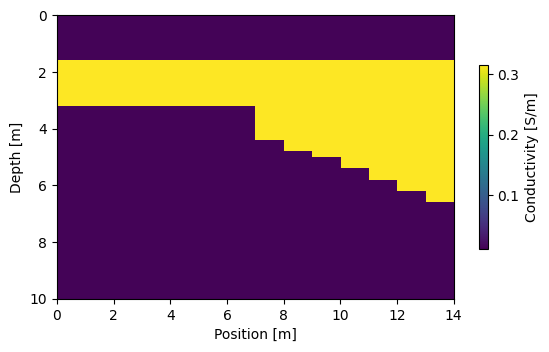

In [50]:
PlotModel(sigmas, depths)

In [51]:
# Inputs for inversion:

# Create empty array for true model in each position
model = []

# Create empty array for true data in each position
data=[]

for i in range(npos):
    model_i = np.hstack((sigmas[i][0], sigmas[i][1], sigmas[i][2], depths[i][1], depths[i][2]))# True model 
    model.append(model_i)
    data.append(EMforward(sigmas[i][0], sigmas[i][1], sigmas[i][2], depths[i][1], depths[i][2])) # creating data
    
# Relative error array
#error = 1e-1 # introduce here the error you want to test
#relativeError = np.ones_like(data[0]) * error

In [52]:
# Start inversion

model_est_list =[] # empty array to store the model estimated

for i in range(npos):   
    dataE = np.array(data[i]).copy()
    #dataE *= np.random.randn(len(dataE)) * relativeError + 1.0

    model_est = invert(gridsearch(dataE))
    
    model_est_list.append(model_est)

# Model estimation array  
model_est_arr = np.array(model_est_list)

In [53]:
sigmas_est = model_est_arr[:,0:3]
depths_est = depths.copy()
depths_est[:,1:] = model_est_arr[:,3:]

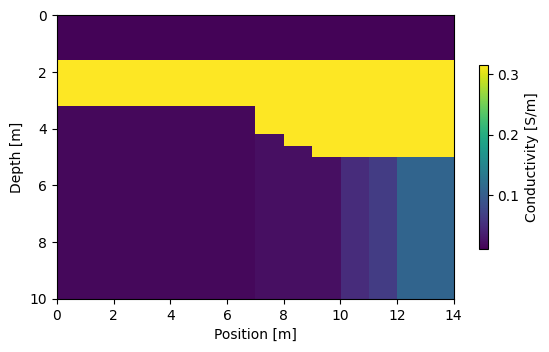

In [54]:
PlotModel(sigmas_est, depths_est)

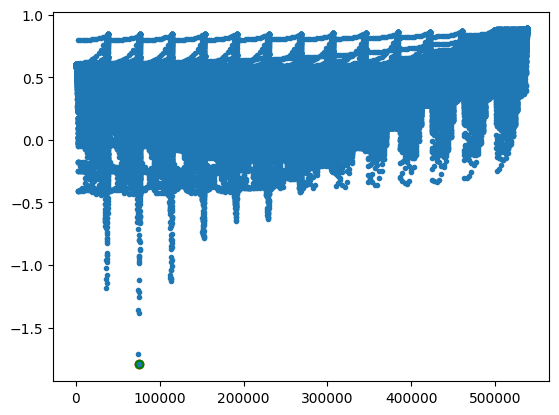

In [55]:
# Check if error is minima

sigma1_true = model[9][0]
sigma2_true = model[9][1]
sigma3_true = model[9][2]
thick1_true = model[9][3]
thick2_true = model[9][4]

Qdata = EMforward(sigma1_true, sigma2_true, sigma3_true, thick1_true, thick2_true)

err=1
merr_arr=[]
for i in range(np.shape(Qexact)[0]):
    nZdiff = np.abs(Qexact[i] - Qdata) **2 / np.abs(Qdata)**2
    merr = (np.log10(np.sqrt(np.sum(nZdiff))))
    merr_arr.append(np.log10(np.sqrt(np.sum(nZdiff))))
    if merr < err:
        indx = i
        err = merr.copy()
        
plt.plot(merr_arr, '.')
plt.scatter(indx, np.min(merr_arr), c='r')
plt.scatter(indx, err, c='g')

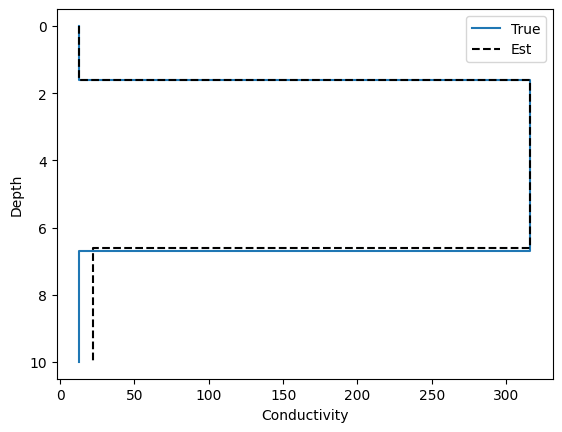

In [56]:
est_model = invert(indx)
plt.figure()
depth_true = np.array([0, thick1_true, thick1_true+thick2_true, 10])
depth_est = np.array([0, est_model[3], est_model[3]+est_model[4], 10])
sigma_true = np.array([sigma1_true, sigma2_true, sigma3_true, sigma3_true])*1000
sigma_est = np.array([est_model[0], est_model[1], est_model[2], est_model[2]])*1000
plt.step(sigma_true, depth_true, label='True')
plt.step(sigma_est, depth_est, '--k' , label='Est')
plt.legend()
plt.xlabel('Conductivity')
plt.ylabel('Depth')
ax = plt.gca()
ax.invert_yaxis()

### Test model that is not in the calculated solutions

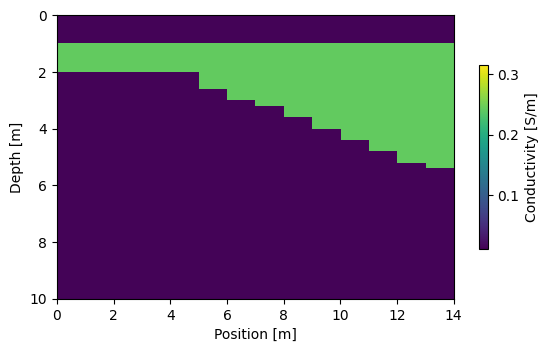

In [69]:
# parameters for the synthetic model

nlayer = 3 # number of layer
npos = 14 # number of sampling positions

sig_ini = [conds[1], conds[12], conds[1]]
sigmas = np.ones((npos, nlayer))*sig_ini

x = np.linspace(0, npos, npos)
thk1 = np.ones_like(x)   # wave

thk2 = np.ones_like(x) *2
thk2[5:]=thicks[5:] + 0.5

depths = np.zeros((npos, nlayer))
depths[:,1] = thk1
depths[:,2] = thk2

PlotModel(sigmas, depths)

In [70]:
# Inputs for inversion:

# Create empty array for true model in each position
model = []

# Create empty array for true data in each position
data=[]

for i in range(npos):
    model_i = np.hstack((sigmas[i][0], sigmas[i][1], sigmas[i][2], depths[i][1], depths[i][2]))# True model 
    model.append(model_i)
    data.append(EMforward(sigmas[i][0], sigmas[i][1], sigmas[i][2], depths[i][1], depths[i][2])) # creating data
    
# Relative error array
#error = 1e-1 # introduce here the error you want to test
#relativeError = np.ones_like(data[0]) * error

In [71]:
# Start inversion

model_est_list =[] # empty array to store the model estimated

for i in range(npos):   
    dataE = np.array(data[i]).copy()
    #dataE *= np.random.randn(len(dataE)) * relativeError + 1.0

    model_est = invert(gridsearch(dataE))
    
    model_est_list.append(model_est)

# Model estimation array  
model_est_arr = np.array(model_est_list)

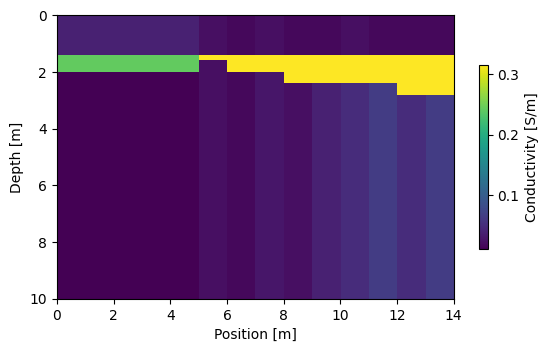

In [72]:
sigmas_est = model_est_arr[:,0:3]
depths_est = depths.copy()
depths_est[:,1:] = model_est_arr[:,3:]

PlotModel(sigmas_est, depths_est)

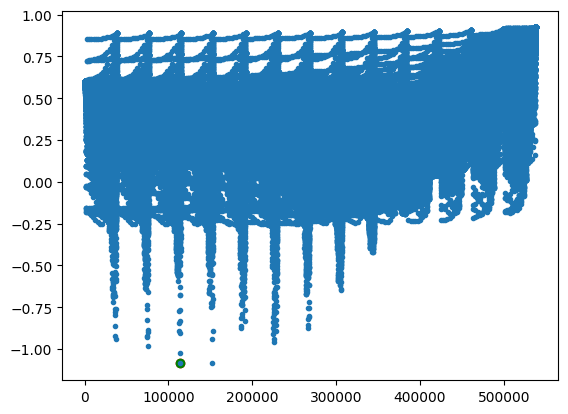

In [75]:
# Check if error is minima

sigma1_true = model[11][0]
sigma2_true = model[11][1]
sigma3_true = model[11][2]
thick1_true = model[11][3]
thick2_true = model[11][4]

Qdata = EMforward(sigma1_true, sigma2_true, sigma3_true, thick1_true, thick2_true)

err=1
merr_arr=[]
for i in range(np.shape(Qexact)[0]):
    nZdiff = np.abs(Qexact[i] - Qdata) **2 / np.abs(Qdata)**2
    merr = (np.log10(np.sqrt(np.sum(nZdiff))))
    merr_arr.append(np.log10(np.sqrt(np.sum(nZdiff))))
    if merr < err:
        indx = i
        err = merr.copy()
        
plt.plot(merr_arr, '.')
plt.scatter(indx, np.min(merr_arr), c='r')
plt.scatter(indx, err, c='g')

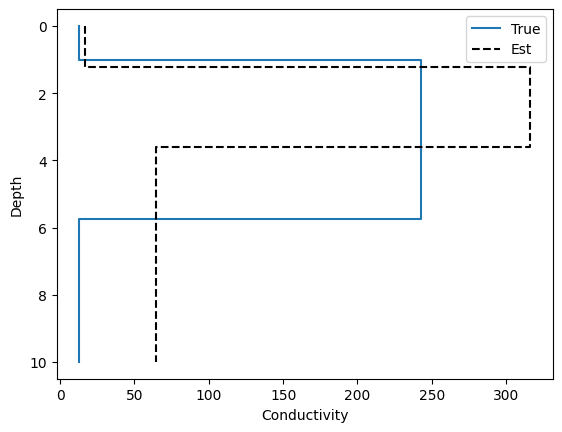

In [76]:
est_model = invert(indx)
plt.figure()
depth_true = np.array([0, thick1_true, thick1_true+thick2_true, 10])
depth_est = np.array([0, est_model[3], est_model[3]+est_model[4], 10])
sigma_true = np.array([sigma1_true, sigma2_true, sigma3_true, sigma3_true])*1000
sigma_est = np.array([est_model[0], est_model[1], est_model[2], est_model[2]])*1000
plt.step(sigma_true, depth_true, label='True')
plt.step(sigma_est, depth_est, '--k' , label='Est')
plt.legend()
plt.xlabel('Conductivity')
plt.ylabel('Depth')
ax = plt.gca()
ax.invert_yaxis()